## Keypoints

* HDF5 is a fast format for storing numerical data
* Dask lets you do larger-than-memory computations
* The abstraction dask.array is much like a numpy.array

In [9]:
cd /scratch3/atrikut

/scratch3/atrikut


In [ ]:
cp -r /home/atrikut/high-performance-python/data/ .

In [ ]:
cp /home/atrikut/high-performance-python/makeData.py .

The following line takes several minutes (~30) to run

In [ ]:
!time python makeData.py

In [1]:
import numpy as np
import h5py
import dask.array as da
import glob
import timeit
import dask
import dask.threaded
import timeit

In [2]:
dask.set_options(get=dask.threaded.get)

In [14]:
import matplotlib.pyplot as plt

In [15]:
%matplotlib inline

In [6]:
!du -h data/weather-big/*

8.2G	data/weather-big/2014-01-01.hdf5
8.2G	data/weather-big/2014-01-02.hdf5
8.2G	data/weather-big/2014-01-03.hdf5
8.2G	data/weather-big/2014-01-04.hdf5
8.2G	data/weather-big/2014-01-05.hdf5
8.2G	data/weather-big/2014-01-06.hdf5
8.2G	data/weather-big/2014-01-07.hdf5
8.2G	data/weather-big/2014-01-08.hdf5
8.2G	data/weather-big/2014-01-09.hdf5
8.2G	data/weather-big/2014-01-10.hdf5
8.2G	data/weather-big/2014-01-11.hdf5
8.2G	data/weather-big/2014-01-12.hdf5
8.2G	data/weather-big/2014-01-13.hdf5
8.2G	data/weather-big/2014-01-14.hdf5
8.2G	data/weather-big/2014-01-15.hdf5
8.2G	data/weather-big/2014-01-16.hdf5
8.2G	data/weather-big/2014-01-17.hdf5
8.2G	data/weather-big/2014-01-18.hdf5
8.2G	data/weather-big/2014-01-19.hdf5
8.2G	data/weather-big/2014-01-20.hdf5
8.2G	data/weather-big/2014-01-21.hdf5
8.2G	data/weather-big/2014-01-22.hdf5
8.2G	data/weather-big/2014-01-23.hdf5
8.2G	data/weather-big/2014-01-24.hdf5
8.2G	data/weather-big/2014-01-25.hdf5
8.2G	data/weather-big/2014-01-26.hdf5
8.2G	data/we

In [ ]:
!du -h data/weather-small/2014-01-01.csv

In [ ]:
!du -h data/weather-small/2014-01-01.hdf5

In [ ]:
%timeit temps = np.loadtxt('data/weather-small/2014-01-01.csv', delimiter=',')

In [ ]:
%timeit temps = h5py.File('data/weather-small/2014-01-02.hdf5')['/t2m'][...]

In [9]:
dset = h5py.File('data/weather-big/2014-01-01.hdf5')['/t2m']

In [10]:
print(dset)

<HDF5 dataset "t2m": shape (23040, 46080), type "<f8">


In [11]:
temps = dset[...] # gets numpy array from HDF5 dataset

In [12]:
temps.shape

(23040, 46080)

In [13]:
temps_da = da.from_array(temps, chunks=(5000, 5000)) # gets a dask array from NumPy array

In [14]:
print(temps_da)

dask.array<array, shape=(23040, 46080), dtype=float64, chunksize=(5000, 5000)>


In [15]:
print(temps_da.shape)

(23040, 46080)


In [21]:
def center(data):
    return data - data.mean()

In [22]:
t1 = timeit.default_timer()
centered_temps = center(temps)
t2 = timeit.default_timer()

In [20]:
print(t2-t1)

13.498517160012852


In [23]:
result = center(temps_da)
t1 = timeit.default_timer()
centered_temps = result.compute(get=dask.threaded.get)
t2 = timeit.default_timer()

In [24]:
print(t2-t1)

4.907631672977004


We can get away with plotting a smaller array:

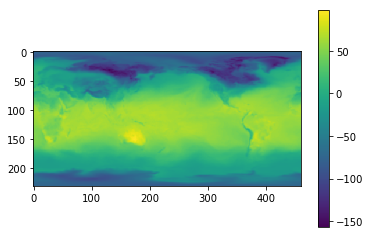

In [25]:
plt.imshow(centered_temps[::100, ::100])
plt.colorbar()

## Using dask.delayed for embarrassingly parallel work

In [46]:
from dask import delayed
import dask.multiprocessing

@delayed
def mean_temp(filename):
    dset = h5py.File(filename)['/t2m']
    temps = dset[...]
    return temps.mean()

In [47]:
results = [mean_temp(filename) for filename in glob.glob('data/weather-medium/*.hdf5')]

In [48]:
print(results)

[Delayed('mean_temp-f9cd9e17-6609-4f91-9c26-c6dae9d14171'), Delayed('mean_temp-02b49cf2-d8ad-4cce-98ec-d4cf9936317d'), Delayed('mean_temp-3c66929a-c7f8-4cb5-b994-6131e99d195a'), Delayed('mean_temp-4defe33f-53f8-4da0-82c2-4c4d3e7fcc0e'), Delayed('mean_temp-2aa751e3-bda2-48d7-abdf-081bc0bd589f'), Delayed('mean_temp-2dc47605-a992-499c-9462-bc0a1dfbdbda'), Delayed('mean_temp-05ee72f6-29ce-4a5d-be24-4e36f894fc69'), Delayed('mean_temp-f20ff776-0480-466a-8944-f90be8cda09c'), Delayed('mean_temp-ea45255e-8da3-4e9e-8c2a-8a364b0c970e'), Delayed('mean_temp-1b9e9f1b-ca7e-469b-a2e1-3de3dd997af6'), Delayed('mean_temp-1817c801-825c-4a0a-8b2f-bc838474360d'), Delayed('mean_temp-361cadd4-49b2-44fc-a01e-dd35239b1910'), Delayed('mean_temp-1ddb8db3-7cc5-4373-9cfc-da24d2a0d574'), Delayed('mean_temp-9969b8b9-d99f-44b2-8470-3341be049f42'), Delayed('mean_temp-016c417d-b38e-421f-a006-4e2b7bf4e48c'), Delayed('mean_temp-6ff749a1-d2af-4e74-bb5a-5d75dd6237f7'), Delayed('mean_temp-c166b7b9-bf60-4f15-999e-3c4685bcea8f

In [54]:
da.compute(*results, get=dask.multiprocessing.get)

(157.04536699459877,
 154.54002483603395,
 160.81113281250001,
 159.86300877700617,
 165.08843967013888,
 168.8551511863426,
 163.73963324652777,
 169.25500602816359,
 167.93880256558643,
 166.51512659143518,
 163.77134018132716,
 161.4648955922068,
 158.83167438271605,
 157.45291546103394,
 159.00699266975309,
 159.88063970871914,
 162.47138189621913,
 162.81344762731482,
 160.52553433641975,
 165.76992645640433,
 167.28410855516975,
 168.03736014660493,
 166.18571855709877,
 163.23281635802468,
 168.09411627121915,
 168.20748963155864,
 166.43696518132717,
 167.64012707368826,
 169.33892336998457,
 169.38287760416668,
 163.98587191358024)